In [1]:
import scipp as sc
import numpy as np
import dataconfig # run make_config.py to create this

In [2]:
def to_bin_centers(d, dim):
    edges = d.coords[dim].copy()
    del d.coords[dim]
    d.coords[dim] = 0.5 * (edges[dim, 1:] + edges[dim, :-1])

In [3]:
def to_bin_edges(d, dim):
    centers = d.coords[dim].copy()
    del d.coords[dim]
    first = 1.5*centers[dim, 0] - 0.5*centers[dim, 1]
    last = 1.5*centers[dim, -1] - 0.5*centers[dim, -2]
    bulk = 0.5 * (centers[dim, 1:] + centers[dim, :-1])
    edges = sc.concatenate(first, bulk, dim)
    edges = sc.concatenate(edges, last, dim)
    d.coords[dim] = edges

In [4]:
def map_to_bins(data, dim, edges):
    data = data.copy()
    to_bin_edges(data, dim)
    bin_width = data.coords[dim][dim,1:] - data.coords[dim][dim,:-1]
    bin_width.unit = sc.units.one
    data *= bin_width
    data = sc.rebin(data, dim, edges)
    bin_width = edges[dim,1:] - edges[dim,:-1]
    bin_width.unit = sc.units.one
    data /= bin_width
    return data

In [5]:
path = dataconfig.data_root
direct_beam_file = 'DirectBeam_20feb_full_v3.dat'
moderator_file = 'ModeratorStdDev_TS2_SANS_LETexptl_07Aug2015.txt'
sample_run_number = 49338
sample_transmission_run_number = 49339
background_run_number = 49334
background_transmission_run_number = 49335
l_collimation = sc.Variable(value=5.0, unit=sc.units.m)
r2 = sc.Variable(value=4.0824829046386295/1000, unit=sc.units.m) # sample aperture radius
r1 = sc.Variable(value=14.433756729740645/1000, unit=sc.units.m) # source aperture radius
dr = sc.Variable(value=8.0/1000, unit=sc.units.m) # virtual ring width on detector
    
def load_larmor(run_number):
    return sc.neutron.load(filename=f'{path}/LARMOR000{run_number}.nxs')

def load_rkh(filename):
    return sc.neutron.load(
           filename=filename,
           mantid_alg='LoadRKH',
           mantid_args={'FirstColumnValue':'Wavelength'})

In [6]:
%%time
sample_trans = load_larmor(sample_transmission_run_number)
sample = load_larmor(sample_run_number)
background_trans = load_larmor(background_transmission_run_number)
background = load_larmor(background_run_number)

Workspace run log 'A1HCent' has unrecognised units: ' '
Workspace run log 'A1HGap' has unrecognised units: ' '
Workspace run log 'A1VCent' has unrecognised units: ' '
Workspace run log 'A1VGap' has unrecognised units: ' '
Workspace run log 'BenchLift' has unrecognised units: ' '
Workspace run log 'BenchStatus' has unrecognised units: ' '
Workspace run log 'Bench_Rot' has unrecognised units: ' '
Workspace run log 'BlockhouseVacuum' has unrecognised units: ' '
Workspace run log 'CJHCent' has unrecognised units: ' '
Workspace run log 'CJHGap' has unrecognised units: ' '
Workspace run log 'CJVCent' has unrecognised units: ' '
Workspace run log 'CJVGap' has unrecognised units: ' '
Workspace run log 'ChangerTranslation' has unrecognised units: ' '
Workspace run log 'Chi' has unrecognised units: ' '
Workspace run log 'CoarseZ' has unrecognised units: ' '
Workspace run log 'FineZ' has unrecognised units: ' '
Workspace run log 'ICP_DAE_TD' has unrecognised units: ' '
Workspace run log 'ICP_SYS_

Workspace run log 'A1HCent' has unrecognised units: ' '
Workspace run log 'A1HGap' has unrecognised units: ' '
Workspace run log 'A1VCent' has unrecognised units: ' '
Workspace run log 'A1VGap' has unrecognised units: ' '
Workspace run log 'BenchLift' has unrecognised units: ' '
Workspace run log 'BenchStatus' has unrecognised units: ' '
Workspace run log 'Bench_Rot' has unrecognised units: ' '
Workspace run log 'BlockhouseVacuum' has unrecognised units: ' '
Workspace run log 'CJHCent' has unrecognised units: ' '
Workspace run log 'CJHGap' has unrecognised units: ' '
Workspace run log 'CJVCent' has unrecognised units: ' '
Workspace run log 'CJVGap' has unrecognised units: ' '
Workspace run log 'ChangerTranslation' has unrecognised units: ' '
Workspace run log 'Chi' has unrecognised units: ' '
Workspace run log 'CoarseZ' has unrecognised units: ' '
Workspace run log 'FineZ' has unrecognised units: ' '
Workspace run log 'ICP_DAE_TD' has unrecognised units: ' '
Workspace run log 'ICP_SYS_

CPU times: user 37.4 s, sys: 53.6 s, total: 1min 31s
Wall time: 1min 13s


In [7]:
%%time
dtype = sample.coords['position'].dtype
sample_pos_offset = sc.Variable(value=[0.0, 0.0, 0.30530], unit=sc.units.m, dtype=dtype)
bench_pos_offset = sc.Variable(value=[0.0, 0.001, 0.0], unit=sc.units.m, dtype=dtype)
for item in [sample, sample_trans, background, background_trans]:
    item.coords['sample-position'] += sample_pos_offset
    item.coords['position'] += bench_pos_offset

CPU times: user 15.6 ms, sys: 31.2 ms, total: 46.9 ms
Wall time: 4.93 ms


In [8]:
%%time
wavelength_bins = sc.Variable(
    dims=['wavelength'],
    unit=sc.units.angstrom,
    values=np.geomspace(0.9, 13.5, num=110))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.39 ms


In [9]:
def apply_masks(data):
    tof = data.coords['tof']
    data.masks['bins'] = sc.less(tof['tof',1:], 1500.0 * sc.units.us) | \
                         (sc.greater(tof['tof',:-1], 17500.0 * sc.units.us) & \
                          sc.less(tof['tof',1:], 19000.0 * sc.units.us))
    pos = sc.neutron.position(data)
    x = sc.geometry.x(pos)
    y = sc.geometry.y(pos)
    data.masks['beam-stop'] = sc.less(sc.sqrt(x*x+y*y), 0.045 * sc.units.m)
    data.masks['tube-ends'] = sc.greater(sc.abs(x), 0.36 * sc.units.m) # roughly all det IDs listed in original
    #MaskDetectorsInShape(Workspace=maskWs, ShapeXML=self.maskingPlaneXML) # irrelevant tiny wedge?

In [10]:
def background_mean(data, dim, begin, end):
    coord = data.coords[dim]
    assert (coord.unit == begin.unit) and (coord.unit == end.unit)
    i = np.searchsorted(coord, begin.value)
    j = np.searchsorted(coord, end.value) + 1
    return data - sc.mean(data[dim, i:j], dim)

In [11]:
def transmission_fraction(incident_beam, transmission):
    # Approximation based on equations in CalculateTransmission documentation
    # TODO proper implementation of mantid.CalculateTransmission
    return (transmission / transmission) * (incident_beam / incident_beam)
    #CalculateTransmission(SampleRunWorkspace=transWsTmp,
    #                      DirectRunWorkspace=transWsTmp,
    #                      OutputWorkspace=outWsName,
    #                      IncidentBeamMonitor=1,
    #                      TransmissionMonitor=4, RebinParams='0.9,-0.025,13.5',
    #                      FitMethod='Polynomial',
    #                      PolynomialOrder=3, OutputUnfittedData=True)

In [12]:
def extract_monitor_background(data, begin, end):
    background = background_mean(data, 'tof', begin, end)
    del background.coords['sample-position'] # ensure unit conversion treats this a monitor
    background = sc.neutron.convert(background, 'tof', 'wavelength')
    background = sc.rebin(background, 'wavelength', wavelength_bins)
    return background

def setup_transmission(data):
    incident_beam = extract_monitor_background(data['spectrum', 0], 40000.0*sc.units.us, 99000.0*sc.units.us)
    transmission = extract_monitor_background(data['spectrum', 3], 88000.0*sc.units.us, 98000.0*sc.units.us)
    return transmission_fraction(incident_beam, transmission)

In [13]:
def solid_angle(data):
    # TODO proper solid angle
    # [0.0117188,0.0075,0.0075] bounding box size
    pixel_size = 0.0075 * sc.units.m 
    pixel_length = 0.0117188 * sc.units.m
    L2 = sc.neutron.l2(data)
    return (pixel_size * pixel_length) / (L2 * L2)

In [14]:
def q_resolution(lam_edges, moderator, d, l_collimation, r1, r2, dr):
    moderator = sc.rebin(moderator, 'wavelength', lam_edges)
    
    d_lam = lam_edges['wavelength', 1:] - lam_edges['wavelength', :-1] # bin widths
    lam = 0.5 * (lam_edges['wavelength', 1:] + lam_edges['wavelength', :-1]) # bin centres
    
    l2 = sc.neutron.l2(d)
    theta = sc.neutron.scattering_angle(d)  
    inv_l3 = (l_collimation + l2) / (l_collimation * l2)
    
    # Terms in Mildner and Carpenter equation.
    # See https://docs.mantidproject.org/nightly/algorithms/TOFSANSResolutionByPixel-v1.html
    a1 = (r1/l_collimation)*(r1/l_collimation) * 3.0
    a2 = (r2*inv_l3)*(r2*inv_l3) * 3.0
    a3 = (dr/l2) * (dr/l2) 
    q_sq = 4.0 * np.pi * sc.sin(theta) * sc.reciprocal(lam) # keep in wav dim to prevent broadcast
    q_sq *= q_sq
    
    tof = moderator.data.copy()
    tof.variances = None # shortcoming of Mantid or Mantid converter?
    tof.rename_dims({'wavelength':'tof'}) # TODO overly restrictive check in convert (rename)
    tof.unit = sc.units.us
    mod = sc.Dataset(coords={
      'tof':tof,
      'position':sample.coords['position'],
      'source_position':sample.coords['source_position'],
      'sample_position':sample.coords['sample_position']})
    s = sc.neutron.convert(mod, 'tof', 'wavelength').coords['wavelength']
    
    std_dev_lam_sq = (d_lam * d_lam)/12 + s * s
    std_dev_lam_sq *= sc.reciprocal(lam * lam)
    f = (4 * np.pi * np.pi) * sc.reciprocal(12 * lam * lam)
   
    return sc.DataArray(f * (a1 + a2 + a3) + (q_sq * std_dev_lam_sq),
                        coords={'wavelength':lam, 'spectrum':d.coords['spectrum'].copy()})

In [15]:
def q1d(data, transmission, l_collimation, r1, r2, dr, wavelength_bands=None):
    transmission = setup_transmission(transmission)
    data = data.copy()
    apply_masks(data)
    data = sc.neutron.convert(data, 'tof', 'wavelength', out=data)
    data = sc.rebin(data, 'wavelength', wavelength_bins)

    monitor = data.coords['monitor1'].value
    monitor = background_mean(monitor, 'tof', 40000.0*sc.units.us, 99000.0*sc.units.us)
    monitor = sc.neutron.convert(monitor, 'tof', 'wavelength', out=monitor)
    monitor = sc.rebin(monitor, 'wavelength', wavelength_bins)

    # this factor seems to be a fudge factor. Explanation pending.
    data *= 100.0 / 176.71458676442586

    # Setup direct beam and normalise to monitor. I.e. adjust for efficiency of detector across the wavelengths.
    direct_beam = load_rkh(filename=f'{path}/{direct_beam_file}')
    # This would work assuming that there is a least one wavelength point per bin
    #direct_beam = sc.groupby(direct_beam, 'wavelength', bins=monitor.coords['wavelength']).mean('wavelength')
    direct_beam = map_to_bins(direct_beam, 'wavelength', monitor.coords['wavelength'])
    direct_beam = monitor * transmission * direct_beam

    # Estimate qresolution function
    moderator = load_rkh(filename=f'{path}/{moderator_file}')
    to_bin_edges(moderator, 'wavelength')

    q_bins = sc.Variable(
        dims=['Q'],
        unit=sc.units.one/sc.units.angstrom,
        values=np.geomspace(0.008, 0.6, num=55))
   
    d = sc.Dataset({'data':data, 'norm':solid_angle(data)*direct_beam})
    #dq_sq = q_resolution(d.coords['wavelength'], moderator, d, l_collimation, r1, r2, dr)
    to_bin_centers(d, 'wavelength')
    d = sc.neutron.convert(d, 'wavelength', 'Q', out=d) # TODO no gravity yet
    
    
    if wavelength_bands is None:
        d = sc.histogram(d, q_bins)
        d = sc.sum(d, 'spectrum')
        I = d['data']/d['norm']
    else:
        # Cut range into number of requested bands
        n_band = int(wavelength_bands)
        n_bin = len(wavelength_bins.values)-1
        bounds = np.arange(n_bin)[::n_bin//n_band]
        bounds[-1] = n_bin
        slices =  [slice(i, j) for i,j in zip(bounds[:-1],bounds[1:])]
        bands = None
        # Reduce by wavelength slice
        for s in slices:
            band = sc.histogram(d['Q', s].copy(), q_bins) # TODO fix scipp to avoid need for copy
            band = sc.sum(band, 'spectrum')
            bands = sc.concatenate(bands, band, 'wavelength') if bands is not None else band
        # Add coord for wavelength edges of bands
        bands.coords['wavelength'] = sc.Variable(
            dims=['wavelength'],
            unit=sc.units.angstrom,
            values=np.take(wavelength_bins.values, bounds))
        I = bands['data']/bands['norm']

    return I

In [23]:
%%time
sample_q1d = q1d(data=sample, transmission=sample_trans, 
                 l_collimation=l_collimation, r1=r1, r2=r2, dr=dr, wavelength_bands=None)
background_q1d = q1d(data=background, transmission=background_trans,
                     l_collimation=l_collimation, r1=r1, r2=r2, dr=dr,  wavelength_bands=None)
reduced = sample_q1d - background_q1d

reduced.coords['UserFile'] = sc.Variable(
    value='USER_Raspino_191E_BCSLarmor_24Feb2020_v1.txt')
reduced.coords['Transmission'] = sc.Variable(
    value=f'{sample_transmission_run_number}_trans_sample_0.9_13.5_unfitted')
reduced.coords['TransmissionCan'] = sc.Variable(
    value=f'{background_transmission_run_number}_trans_can_0.9_13.5_unfitted')

CPU times: user 17.4 s, sys: 58.1 s, total: 1min 15s
Wall time: 43.3 s


In [17]:
reduced

<scipp.DataArray>
Dimensions: {{Q, 54}}
Coordinates:
    Q                         float64    [Å^-1]         (Q [bin-edges])  [0.008000, 0.008666, ..., 0.553896, 0.600000]
    Transmission              string     [dimensionless]  ()  ["49339_trans_sample_0.9_13.5_unfitted"]
    TransmissionCan           string     [dimensionless]  ()  ["49335_trans_can_0.9_13.5_unfitted"]
    UserFile                  string     [dimensionless]  ()  ["USER_Raspino_191E_BCSLarmor_24Feb2020_v1.txt"]
    sample-position           vector_3_float64  [m]              ()  [(0.000000, 0.000000, 25.605300)]
    source-position           vector_3_float64  [m]              ()  [(0.000000, 0.000000, 0.000000)]
Data:
                              float64    [dimensionless]  (Q)  [3.141020, 3.883868, ..., 0.011206, 0.003923]  [0.000119, 0.000127, ..., 0.000000, 0.000000]

<IPython.core.display.Javascript object>


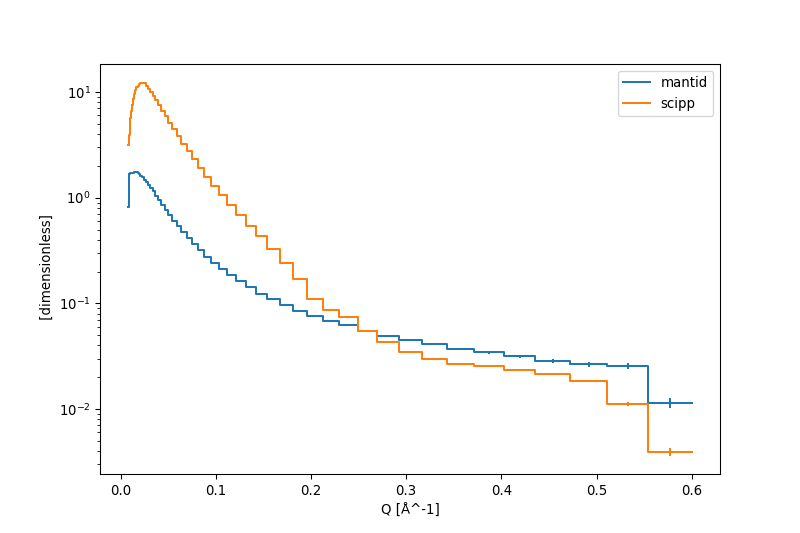

In [24]:
from scipp.plot import plot
values, stddev = np.loadtxt("mantid_reduced.txt")
q = np.loadtxt("mantid_reduced_q.txt")

mantid = sc.DataArray(data=sc.Variable(['Q'],
                                       values=values,
                                       variances=stddev*stddev),
                      coords={'Q': sc.Variable(['Q'], unit=sc.units.one/sc.units.angstrom, values=q)})
mantid = sc.rebin(mantid, 'Q', reduced.coords['Q'])

ds = sc.Dataset({'mantid': mantid, 'scipp': reduced})
plot(ds, logy=True)

In [19]:
%%time
sample_q1d = q1d(data=sample,l_collimation=l_collimation, r1=r1, r2=r2, dr=dr, transmission=sample_trans, wavelength_bands=7)
background_q1d = q1d(data=background, l_collimation=l_collimation, r1=r1, r2=r2, dr=dr, transmission=background_trans, wavelength_bands=7)
reduced = sample_q1d - background_q1d

CPU times: user 30 s, sys: 1min 21s, total: 1min 51s
Wall time: 1min 6s


In [20]:
reduced

<scipp.DataArray>
Dimensions: {{wavelength, 7}, {Q, 54}}
Coordinates:
    Q                         float64    [Å^-1]         (Q [bin-edges])  [0.008000, 0.008666, ..., 0.553896, 0.600000]
    sample-position           vector_3_float64  [m]              ()  [(0.000000, 0.000000, 25.605300)]
    source-position           vector_3_float64  [m]              ()  [(0.000000, 0.000000, 0.000000)]
    wavelength                float64    [Å]            (wavelength [bin-edges])  [0.900000, 1.306441, ..., 8.420290, 13.500000]
Data:
                              float64    [dimensionless]  (wavelength, Q)  [0.000000, 0.000000, ..., -nan, -nan]  [0.000000, 0.000000, ..., -nan, -nan]

In [21]:
plot(reduced, collapse='Q', logy=True)
plot(reduced, log=False) # TODO log plot with NANs, and fix https://github.com/scipp/scipp/issues/1112

TypeError: plot_2d() got an unexpected keyword argument 'collapse'